In [5]:
#Input file locations
inputTrace = "/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/20190426_Traces_S13_AN5.csv"
inputEventTrace = "/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/AN5Events_S1S2S3.csv"
inputCueTime = "/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/cue_times/20190426_AN5_S13b.csv"
inputcelllocation = "/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/20190426_Traces_S13_AN5-props.csv"

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from itertools import cycle
import statistics
from scipy import stats
from scipy.stats.stats import pearsonr   


data_trace = pd.read_csv(inputTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")

#create pandas format of csv data
data_event = pd.read_csv(inputEventTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
cue_time = pd.read_csv(inputCueTime, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
cell_location = pd.read_csv(inputcelllocation, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")

#Optional this finds the index where session 1 ends and cuts off anything else 
mask = np.column_stack([data_event[col].str.contains("S2", na=False) for col in data_event])
find_result = np.where(mask==True)[0][0]
data_event = data_event[0:find_result]

# Rearrange data so that time is the index, cell name becomes each column header and value becomes the data
data_event = data_event.pivot(index='Time', columns=' Cell Name', values=' Value')
data_event.fillna(value=0, inplace=True, axis=1)
data_event.index = data_event.index.map(float) 
data_event = data_event.sort_index(axis=0)

#Remove any unwanted cell data from cell positions
cell_names = list(data_event)
cell_names = [i.strip() for i in cell_names]
cell_names_trace = list(data_trace.columns.values)[1:]
cell_names_loca = cell_location['Name']

for i in range(len(cell_names_loca)):
    if cell_names_loca[i] not in cell_names:
        cell_location = cell_location.drop([i])
        data_trace = data_trace.drop(cell_names_trace[i], 1)      
        
#Extracts the time periods of the cue times (Code Needs to be optimised )
cue_time = pd.read_csv(inputCueTime, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
cue_time = cue_time.sort_values('Choice')
cue_time_all_r = np.array([cue_time[3:]['Cue Time']]).astype(float).transpose()
cue_time_all_l = np.array([cue_time[0:3]['Cue Time']]).astype(float).transpose()
reward_time = np.array([cue_time['Reward time']]).astype(float).transpose()

cue_time = cue_time.sort_values('Outcome',  ascending=False)
cue_time = cue_time[0:5]
cue_time = cue_time.sort_values('Choice')
cue_time_r = np.array([cue_time[2:5]['Cue Time']]).astype(float).transpose()
cue_time_l = np.array([cue_time[0:2]['Cue Time']]).astype(float).transpose()

In [7]:
#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '30'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['ytick.labelsize'] = '20'

#Legend colour settings
all_events = mpatches.Patch(color='gray', label='Entire Session')
cue_r = mpatches.Patch(color='mediumseagreen', label='Decision Right')
cue_l = mpatches.Patch(color='dodgerblue', label='Decision Left')
reward = mpatches.Patch(color='gold', label='Reward')

In [8]:
# print(neurons_all)
# # #Mi 0.0424,  0.0078
# # #JE 8.5408,  8.5528

print('d1&2 = ', (1-(0.0424/8.5408)))
print('d2&3 = ', (1-(0.0078/8.5528)))      

print(np.array(neurons_all))

d1&2 =  0.9950355938553765
d2&3 =  0.9990880179590309


NameError: name 'neurons_all' is not defined

In [84]:
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/demos/python")
import readFloatsFile

# Add JIDT jar library to the path
jarLocation = "/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
# startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

# # 0. Load/prepare the data:
# # dataRaw = readFloatsFile.readFloatsFile("/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/data_trace_new2.csv")
# # As numpy array:

data = np.array(neurons_all).transpose()

# data = numpy.array(dataRaw)
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
calc = calcClass()
# # 2. Set any properties to non-default values:
calc.setProperty("k", "3")

# # Compute for all pairs:
mi_all = []
for s in range(84):
    mi = []
    for d in range(84):
        # For each source-dest pair:
# #         if (s == d):
# #             continue
        source = data[:, s]
        destination = data[:, d]

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.setObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()
        mi.append(result)
#         print("MI_Kraskov (KSG) alg. 2(col_%d -> col_%d) = %.4f nats" %
#             (s, d, result))
    mi_all.append(mi)


In [91]:
# Add JIDT jar library to the path
jarLocation = "/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
# startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

# 0. Load/prepare the data:
# dataRaw = readFloatsFile.readFloatsFile("/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/data_trace_new.csv")
# As numpy array:

data = np.array(neurons_all).transpose()

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kozachenko").EntropyCalculatorMultiVariateKozachenko
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values

# Compute for all variables:
s = []
for v in range(84):
    # For each variable:
    variable = data[:, v]

    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(variable)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    s.append(result)
#     print("H_Kozachenko-Leonenko(col_%d) = %.4f nats" %
#         (v, result))


In [257]:
import math

def joint_entropy(entropy_x, entropy_y, i_xy):
    joint_entropy = entropy_x+entropy_y-i_xy
    return joint_entropy

def infodistance(i_xy, joint_entropy):
    d = 1-(i_xy/joint_entropy)
#     d = joint_entropy - i_xy
    return d

mi_bits_all = math.log2(math.e) * np.array(mi_all)
# s_bits = math.log2(math.e) * np.array(s)

new_mi_bits_all = []
for i in mi_bits_all:
    new_mi = []
    for j in i:
        if j >1:
            new_mi.append(np.nan)
        else:
            new_mi.append(j)
    new_mi_bits_all.append(new_mi)
    
new_mi_all = []
for i in mi_all:
    new_mi = []
    for j in i:
        if j >1:
            new_mi.append('nan')
        else:
            new_mi.append(j)
    new_mi_all.append(new_mi)

joint_entropy_all = []
d_all = []
d_crutchfield_all = []
for i in range(len(s_bits)):
    je = []
    d = []
    d_crutchfield = []
    for j in range(len(s_bits)):
        je.append(joint_entropy(s_bits[i], s_bits[j], new_mi_bits_all[i][j]))
        d.append(infodistance(new_mi_bits_all[i][j], je[j]))
        d_crutchfield.append(s_bits[i]+s_bits[j]-(2*new_mi_bits_all[i][j]))
    joint_entropy_all.append(je)
    d_crutchfield_all.append(d_crutchfield)
    d_all.append(d)

ValueError: Distance matrix 'X' must be symmetric.

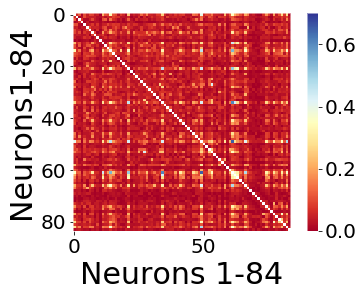

In [213]:
# ax = sns.heatmap(new_mi_bits_all, cmap='RdYlBu')
plt.imshow(new_mi_bits_all, cmap='RdYlBu', interpolation='nearest',  vmin = 0, vmax = 0.7)

# plt.title("Neuron:Neuron Hamming distance over entire session")
plt.xlabel("Neurons 1-84" )
plt.ylabel("Neurons1-84")
plt.yticks(rotation=0)
plt.colorbar()
plt.show()


(0, 0.1)

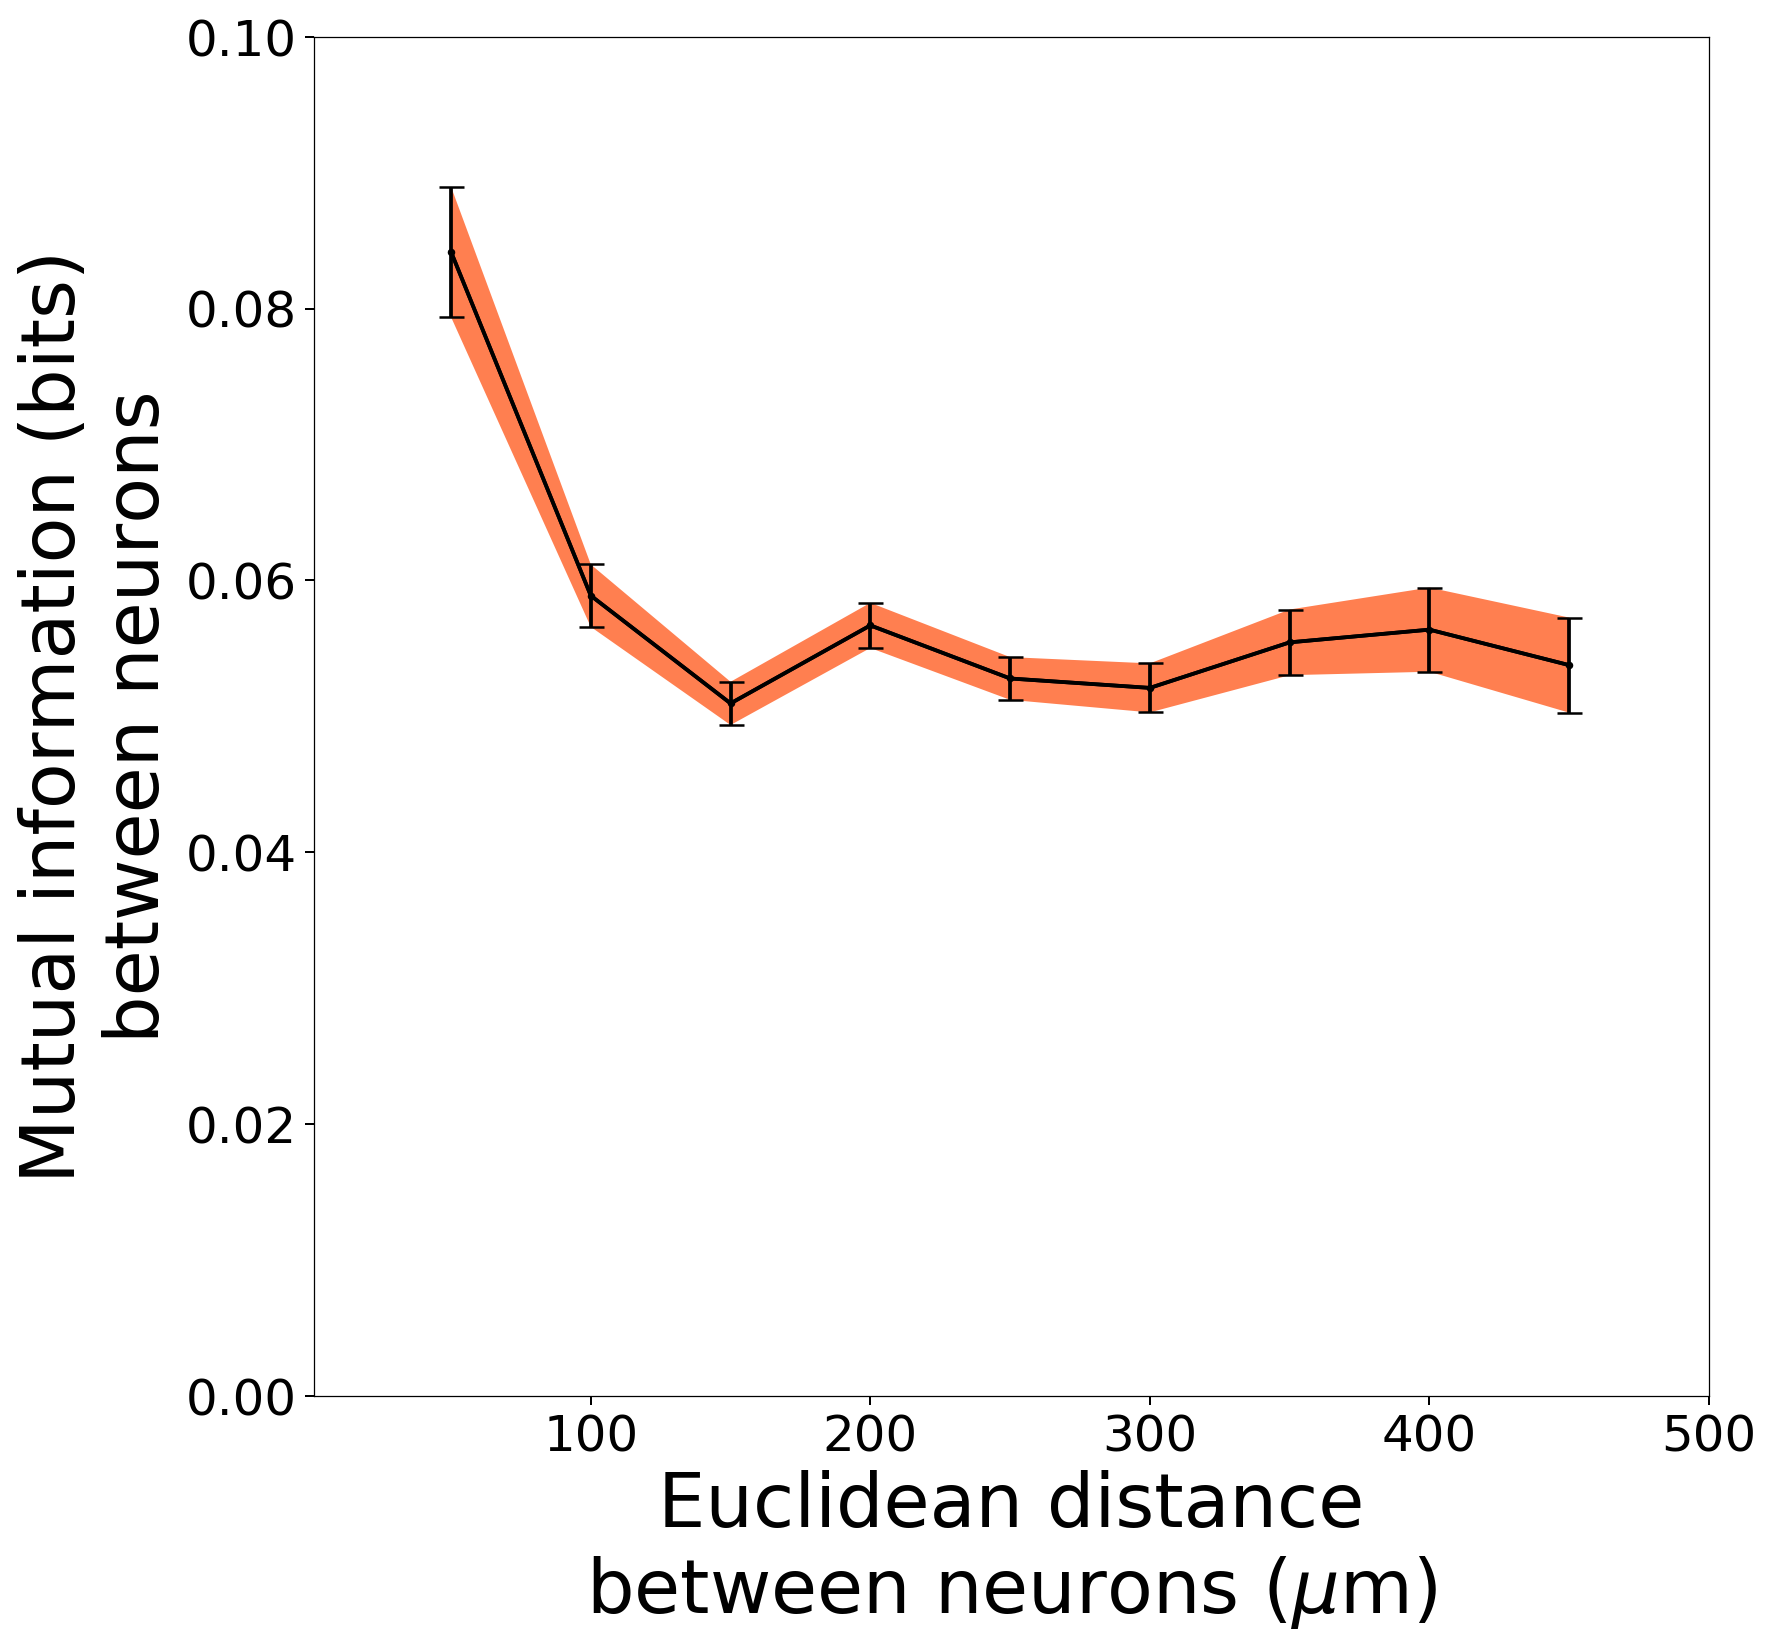

In [14]:
#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '30'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['ytick.labelsize'] = '20'

#Legend colour settings
all_events = mpatches.Patch(color='gray', label='Entire Session')
cue_r = mpatches.Patch(color='mediumseagreen', label='Decision Right')
cue_l = mpatches.Patch(color='dodgerblue', label='Decision Left')
reward = mpatches.Patch(color='gold', label='Reward')


def euc_dis(neuron_selection, cell_coordinates):
    # Input a selection of neurons, or the entire matrix of events
    #The second option uses indexes as neurons
    if isinstance(neuron_selection,list):
        euc_dis_all = []
        for i in neuron_selection:
            euc_dis = []
            for j in neuron_selection:
                euc_dis.append(distance.euclidean(cell_coordinates[i], cell_coordinates[j])/1.42)
            euc_dis_all.append(euc_dis)
    else:
        euc_dis_all = []
        for i in range(len(neuron_selection)):
            euc_dis = []
            for j in range(len(neuron_selection)):
                euc_dis.append(distance.euclidean(cell_coordinates[i], cell_coordinates[j])/1.42)
            euc_dis_all.append(euc_dis)
    return euc_dis_all

cell_coordinates = np.array([cell_location["CentroidX"].astype(float), cell_location["CentroidY"].astype(float)]).transpose()
euc_dis_all = euc_dis(np.array(neurons_all), cell_coordinates)

window_size = 50
window_edge = window_size
window_start = 1
avg_cross_cor_all = []
error_cross_cor_all = []
euc_dis_windows = []

while window_edge <500:  
    avg_neuron_cross_cor = []
    for neuron in range(len(euc_dis_all)):
        for i in range(len(euc_dis_all[neuron])):
            if window_start <= euc_dis_all[neuron][i] <= window_edge:
                avg_neuron_cross_cor.append(new_mi_bits_all[neuron][i])
    avg_cross_cor_all.append(statistics.mean(avg_neuron_cross_cor))
    error_cross_cor_all.append(stats.sem(avg_neuron_cross_cor))
    euc_dis_windows.append(window_edge)
    window_edge+=window_size
    window_start+=window_size

x_axis = euc_dis_windows #Euclidean distance 
y_axis = avg_cross_cor_all #cross cor distance

fig = plt.figure(num=None, figsize=(10, 10), dpi=180, facecolor='w', edgecolor='k')
plt.plot(x_axis, y_axis, color = 'k')
plt.errorbar(x_axis, y_axis, yerr=error_cross_cor_all, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')

plt.fill_between(np.array(x_axis), np.array(y_axis)-np.array(error_cross_cor_all), np.array(y_axis)+np.array(error_cross_cor_all), facecolor='coral')
plt.xlabel(r'Euclidean distance' + '\n' + 'between neurons ($\mu$m)')
plt.ylabel('Mutual information (bits)' + '\n' + 'between neurons')    
plt.xlim(1, 500)
plt.ylim(0, 0.1)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()



(0.99, 1)

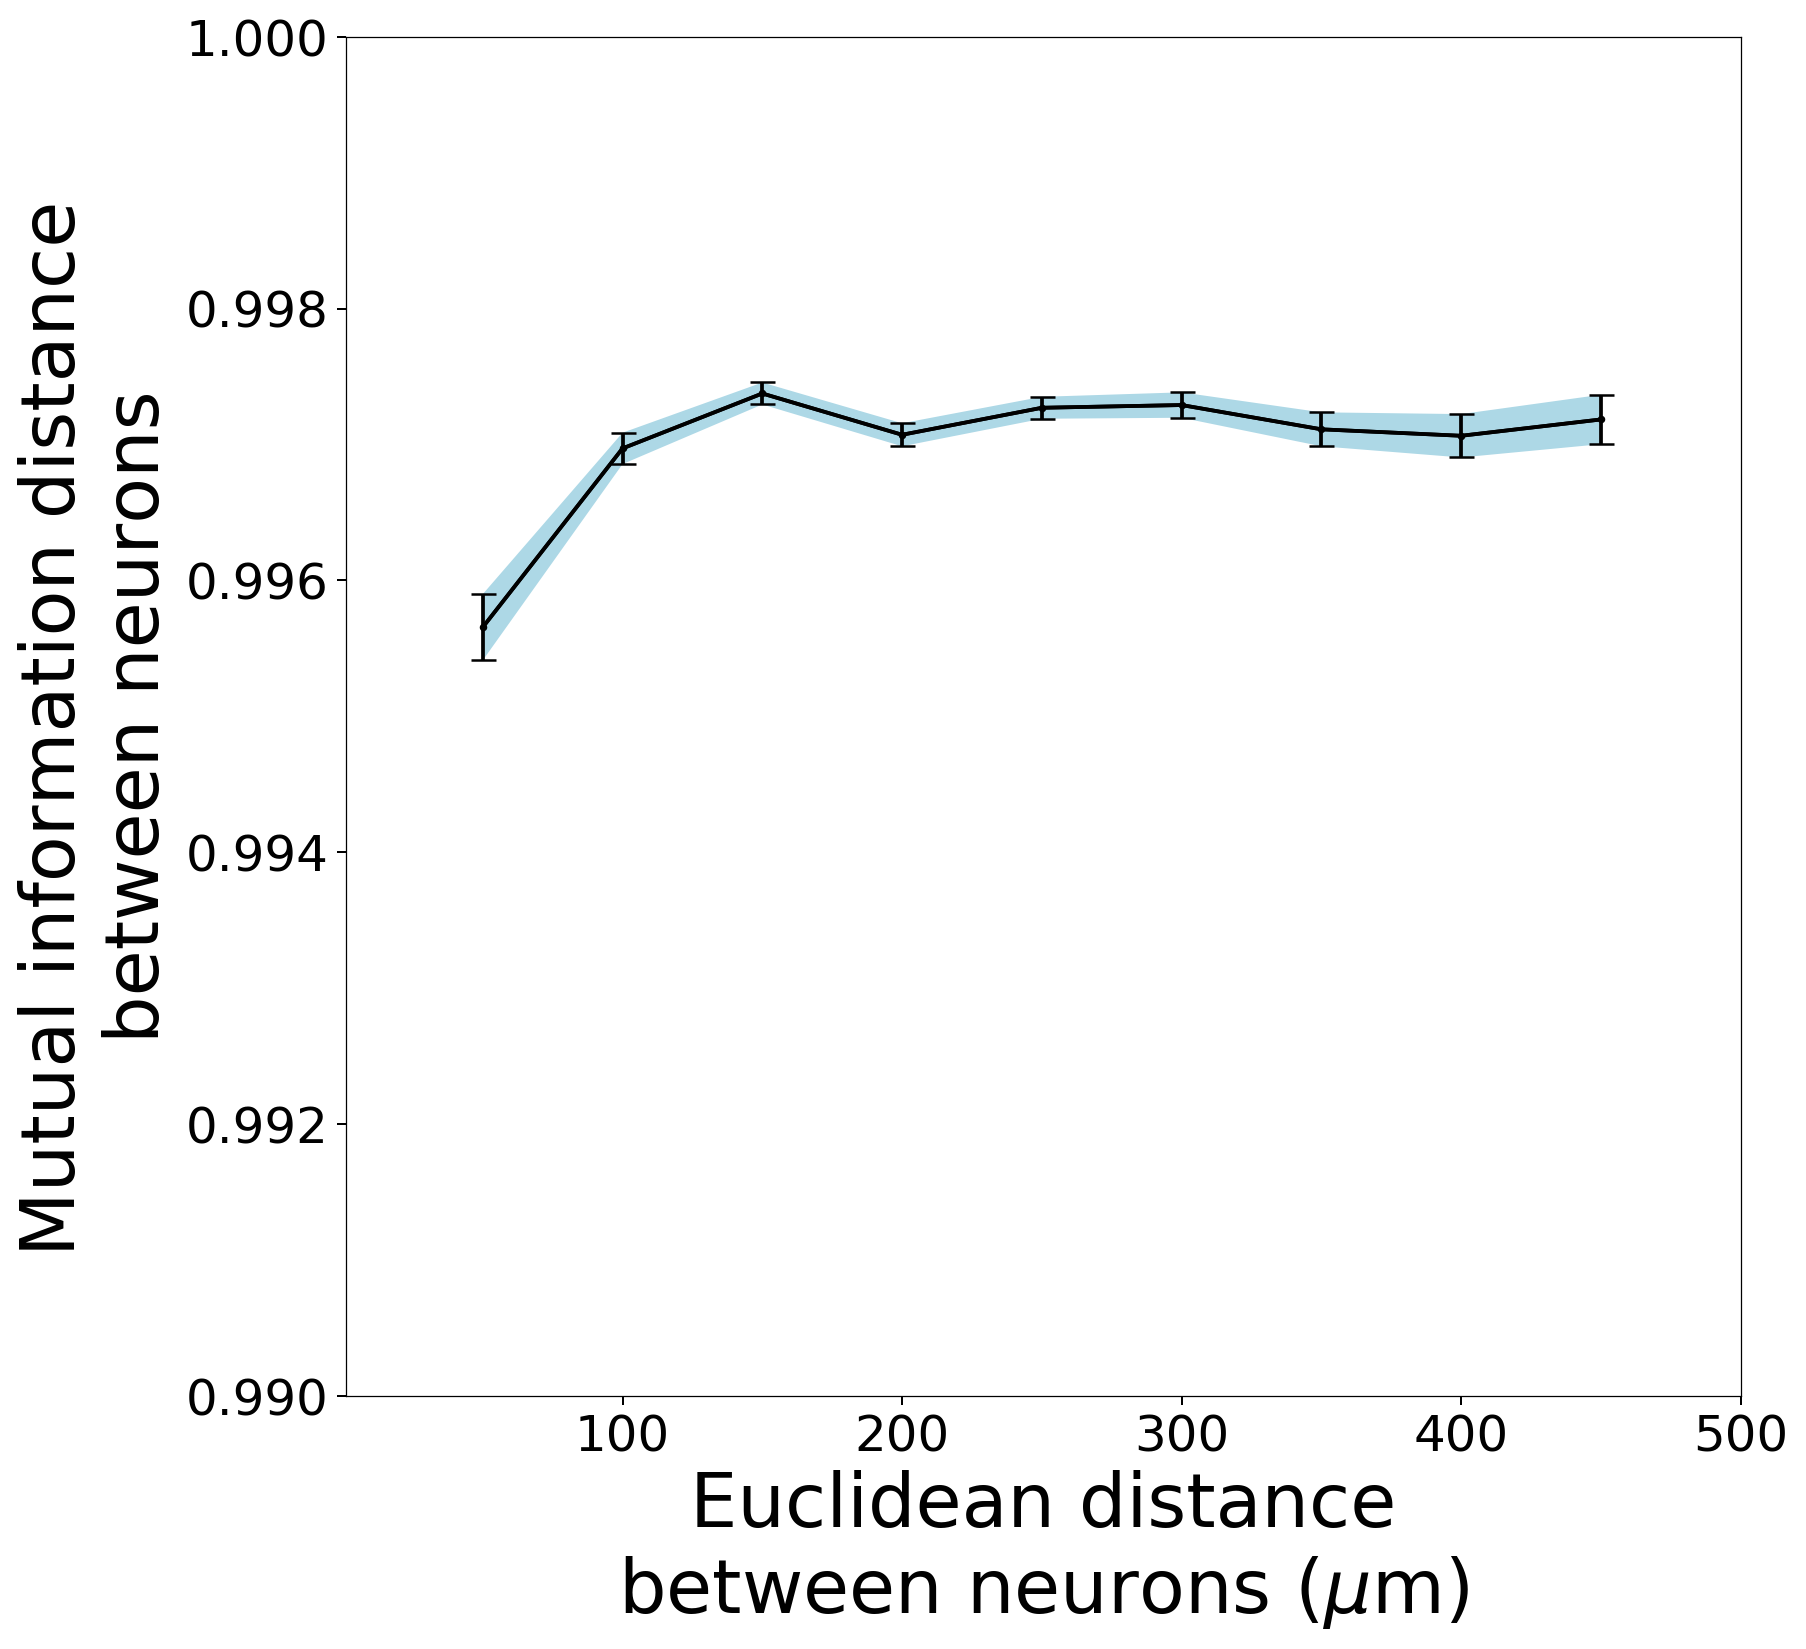

In [300]:
#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '30'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['ytick.labelsize'] = '20'

#Legend colour settings
all_events = mpatches.Patch(color='gray', label='Entire Session')
cue_r = mpatches.Patch(color='mediumseagreen', label='Decision Right')
cue_l = mpatches.Patch(color='dodgerblue', label='Decision Left')
reward = mpatches.Patch(color='gold', label='Reward')


def euc_dis(neuron_selection, cell_coordinates):
    # Input a selection of neurons, or the entire matrix of events
    #The second option uses indexes as neurons
    if isinstance(neuron_selection,list):
        euc_dis_all = []
        for i in neuron_selection:
            euc_dis = []
            for j in neuron_selection:
                euc_dis.append(distance.euclidean(cell_coordinates[i], cell_coordinates[j])/1.42)
            euc_dis_all.append(euc_dis)
    else:
        euc_dis_all = []
        for i in range(len(neuron_selection)):
            euc_dis = []
            for j in range(len(neuron_selection)):
                euc_dis.append(distance.euclidean(cell_coordinates[i], cell_coordinates[j])/1.42)
            euc_dis_all.append(euc_dis)
    return euc_dis_all

cell_coordinates = np.array([cell_location["CentroidX"].astype(float), cell_location["CentroidY"].astype(float)]).transpose()
euc_dis_all = euc_dis(np.array(neurons_all), cell_coordinates)

window_size = 50
window_edge = window_size
window_start = 1
avg_cross_cor_all = []
error_cross_cor_all = []
euc_dis_windows = []

while window_edge <500:  
    avg_neuron_cross_cor = []
    for neuron in range(len(euc_dis_all)):
        for i in range(len(euc_dis_all[neuron])):
            if window_start <= euc_dis_all[neuron][i] <= window_edge:
                avg_neuron_cross_cor.append(d_all[neuron][i])
    avg_cross_cor_all.append(statistics.mean(avg_neuron_cross_cor))
    error_cross_cor_all.append(stats.sem(avg_neuron_cross_cor))
    euc_dis_windows.append(window_edge)
    window_edge+=window_size
    window_start+=window_size

x_axis = euc_dis_windows #Euclidean distance 
y_axis = avg_cross_cor_all #cross cor distance

fig = plt.figure(num=None, figsize=(10, 10), dpi=180, facecolor='w', edgecolor='k')
plt.plot(x_axis, y_axis, color = 'k')
plt.errorbar(x_axis, y_axis, yerr=error_cross_cor_all, capsize=5, ecolor='k',  marker='o',markersize=2, color='k')

plt.fill_between(np.array(x_axis), np.array(y_axis)-np.array(error_cross_cor_all), np.array(y_axis)+np.array(error_cross_cor_all), facecolor='lightblue')
plt.xlabel(r'Euclidean distance' + '\n' + 'between neurons ($\mu$m)')
plt.ylabel('Mutual information distance ' + '\n' + 'between neurons')    
plt.xlim(1, 500)
plt.ylim(0.99, 1)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()



In [15]:
from jpype import *
import numpy
import math
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/demos/python")
import readFloatsFile

# Add JIDT jar library to the path
jarLocation = "/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
# startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

# # 0. Load/prepare the data:
# # dataRaw = readFloatsFile.readFloatsFile("/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/data_trace_new2.csv")
# # As numpy array:

data = np.array(neurons_all).transpose()

source = data[:,0]
destination = data[:,1]

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("k", "3")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("MI_Kraskov (KSG) alg. 2(col_0 -> col_1) = %.4f bits" %
    ((math.log2(math.e)) * result))


MI_Kraskov (KSG) alg. 2(col_0 -> col_1) = 0.0611 bits


 ...]

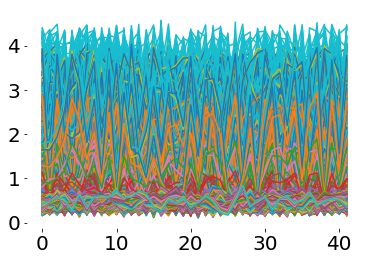

In [262]:
import random
from scipy import ndimage

seed = random.seed(len(neurons_all[0]))

event_every = 100
event_scaler = 20
events_matrix = np.ones(len(neurons_all[0]))
events_matrix[event_every-1::event_every] = [x * event_scaler for x in events_matrix[event_every-1::event_every]]

surrogate1 = []
for i in range(42):
    sigma = 2
    rand = np.random.rand(len(neurons_all[0]))
    surrogate1.append(ndimage.gaussian_filter1d(np.random.rand(len(neurons_all[0])) * events_matrix, sigma))
    


In [250]:
seed = random.seed(len(neurons_all[0]))

event_every = 333
event_scaler = 20
events_matrix = np.ones(len(neurons_all[0]))
events_matrix[event_every-1::event_every] = [x * event_scaler for x in events_matrix[event_every-1::event_every]]

surrogate2 = []
for i in range(42):
    sigma = 2
    rand = np.random.rand(len(neurons_all[0]))
    surrogate2.append(ndimage.gaussian_filter1d(np.random.rand(len(neurons_all[0])) * events_matrix, sigma))
    
surrogate = surrogate1 + surrogate2


84


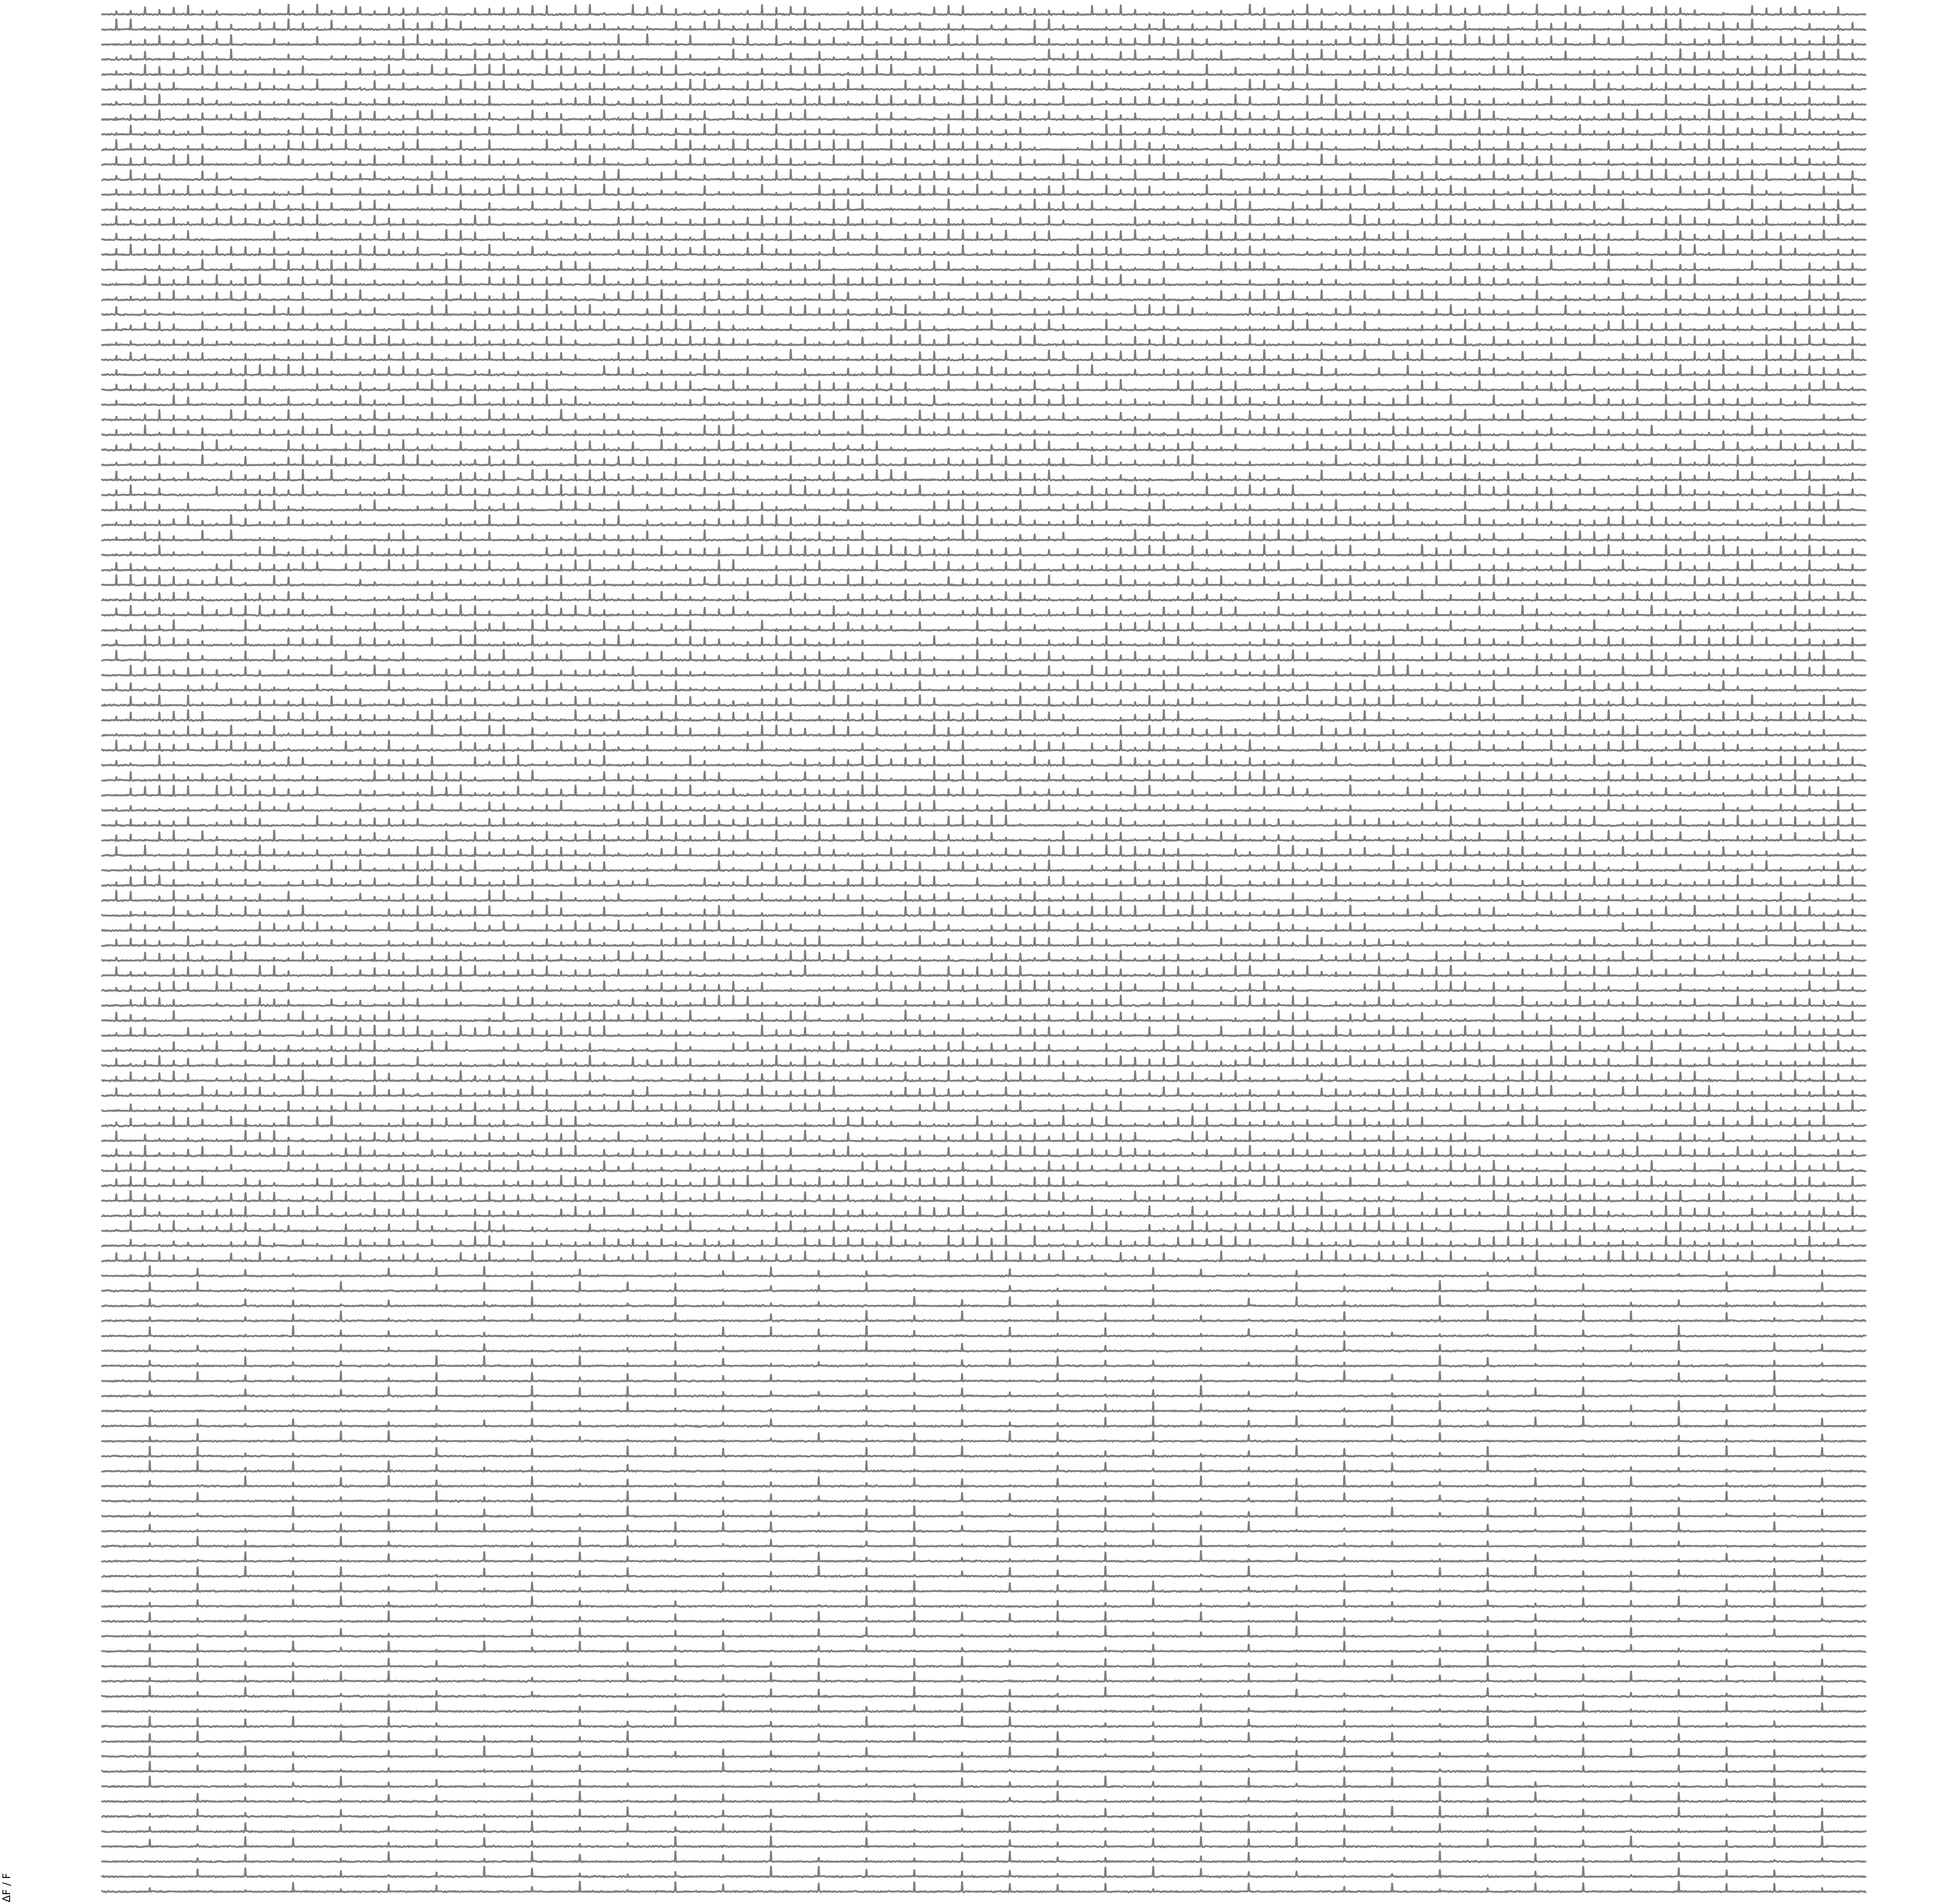

In [239]:

mpl.rcParams['axes.edgecolor'] = 'White'
mpl.rcParams['axes.linewidth'] = '0.5'

from itertools import cycle
cycol = cycle('bgrcmk')
trace_time = np.arange(0, len(surrogate[0])/20, 0.05)

columns = 1
rows = len(surrogate)
fig, ax_array = plt.subplots(rows, columns, figsize=(100, 100), squeeze=False)
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_facecolor('xkcd:white')
        axes.plot(trace_time.astype(float), surrogate[i].astype(float), c='gray', linewidth=5)
        axes.get_yaxis().set_ticks([])
        axes.get_xaxis().set_visible(False)
                                   
axes.set_xlabel('Time (s)')
axes.set_ylabel('ΔF / F')
plt.show()


In [251]:
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/demos/python")
import readFloatsFile

# Add JIDT jar library to the path
jarLocation = "/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
# startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

# # 0. Load/prepare the data:
# # dataRaw = readFloatsFile.readFloatsFile("/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/data_trace_new2.csv")
# # As numpy array:

data = np.array(surrogate).transpose()

# data = numpy.array(dataRaw)
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
calc = calcClass()
# # 2. Set any properties to non-default values:
calc.setProperty("k", "3")

# # Compute for all pairs:
mi_all_surrogate = []
for s in range(84):
    mi = []
    for d in range(84):
        # For each source-dest pair:
# #         if (s == d):
# #             continue
        source = data[:, s]
        destination = data[:, d]

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.setObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()
        mi.append(result)
#         print("MI_Kraskov (KSG) alg. 2(col_%d -> col_%d) = %.4f nats" %
#             (s, d, result))
    mi_all_surrogate.append(mi)


In [252]:
mi_all_surrogate2 = math.log2(math.e) * np.array(mi_all_surrogate)

new_mi_bits_all_surrogate = []
for i in mi_all_surrogate2:
    new_mi = []
    for j in i:
        if j >1:
            new_mi.append(np.nan)
        else:
            new_mi.append(j)
    new_mi_bits_all_surrogate.append(new_mi)


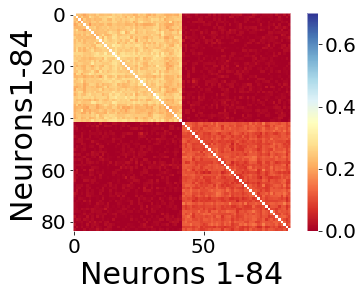

In [253]:
# ax = sns.heatmap(mi_all_surrogate, cmap='RdYlBu')

# plt.show
plt.imshow(new_mi_bits_all_surrogate, cmap='RdYlBu', interpolation='nearest', vmin =0, vmax = 0.7)

# plt.title("Neuron:Neuron Hamming distance over entire session")
plt.xlabel("Neurons 1-84" )
plt.ylabel("Neurons1-84")
plt.yticks(rotation=0)
plt.colorbar()
plt.show()